In [1]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy

import os
import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle, Aggregator
from src.algorithms.rl import EnergyCommunityMultiHouseholdsEnv_v0

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

# Add the aggregator, prices are shared across households
aggregator = Aggregator(name='aggregator_1',
                        imports=np.zeros(data.peers['buy_price'][0].shape),
                        exports=np.zeros(data.peers['buy_price'][0].shape),
                        import_max=data.peers['import_contracted_p_max'][0],
                        export_max=data.peers['export_contracted_p_max'][0],
                        import_cost=data.peers['buy_price'][0],
                        export_cost=data.peers['sell_price'][0]
                        )

max_timesteps = aggregator.imports.shape[0]
# Generate the households
# For simplicity, we assume there are as many households as there are loads
for i in range(data.load['p_forecast'].shape[0]):
    household_resources = {}
    # Add the loads
    household_resources['load']=Load(name='load_{:02d}'.format(i + 1),
                                    value=data.load['p_forecast'][i],
                                    cost_cut=data.load['cost_cut'][i],
                                    cost_reduce=data.load['cost_reduce'][i],
                                    cost_ens=data.load['cost_ens'][i])

    # Add the generators
    household_resources['generator'] = Generator(name='generator_{:02d}'.format(i + 1),
                                         value=np.zeros(data.generator['p_forecast'][0].shape),
                                         lower_bound=np.zeros(data.generator['p_forecast'].shape),
                                         upper_bound=data.generator['p_forecast'][i],
                                         cost=data.generator['cost_parameter_b'][i],
                                         cost_nde=data.generator['cost_nde'][i],
                                         is_renewable=data.generator['type_generator'][i])

    # Add the storage
    if i < data.storage['p_charge_limit'].shape[0]:
        household_resources['storage']=(Storage(name='storage_{:02d}'.format(i + 1),
                                           value=np.zeros(data.storage['p_charge_limit'][0].shape),
                                           cost_discharge=data.storage['discharge_price'][i],
                                           cost_charge=data.storage['charge_price'][i],
                                           capacity_max=data.storage['energy_capacity'][i],
                                           capacity_min=0,
                                           initial_charge=data.storage['initial_state'][i],
                                           discharge_efficiency=data.storage['discharge_efficiency'][i],
                                           charge_efficiency=data.storage['charge_efficiency'][i],
                                           discharge_max=data.storage['p_discharge_max'][i],
                                           charge_max=data.storage['p_charge_max'][i],
                                           capital_cost=0))

    household_resources['aggregator'] = deepcopy(aggregator)
    resources.append(household_resources)


In [4]:
# Create the environment and check if everything is ok
import_penalty = 5000
export_penalty = 5000
storage_action_reward = 0
storage_action_penalty = 5000
balance_penalty = 0
# TODO: Take costs from the excel file
temp_env = EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources, import_penalty=import_penalty,
                                                export_penalty=export_penalty,
                                                storage_action_penalty=storage_action_penalty,
                                                storage_action_reward=storage_action_reward,
                                                balance_penalty=balance_penalty,
                                                max_timesteps=max_timesteps)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.households}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Reward: {0: -0.0, 1: -25011098.040341124, 2: 0.4, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -25009525.57949872, 1: 1.2, 2: -145730.71285074868, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -0.0, 1: -18184.3025970459, 2: -49858.28852496745, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -0.0, 1: 11.417790985107422, 2: -152217.90033854166, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -0.0, 1: -25112519.209139097, 2: 4.425170040130615, 3: -0.0, 4: -0.0, 5: -0.0}
Reward: {0: -26228.853956626404, 1: 0.44478530883789064, 2: 0.4, 3: -0.06451579615015574, 4: 0.004506593753844518, 5: -0.21430239470720291}
Reward: {0: -0.7543523939226756, 1: -238934.01284503937, 2: -48882.316766626594, 3: -0.4163984987186128, 4: -0.18419397908833046, 5: -1.7066424708013535}
Reward: {0: -36476.0038690445, 1: -25040372.227962494, 2: -10.0, 3: -1.3998501007714008, 4: -0.7299080394826033, 5: -2.2904734400632383}
Reward: {0: -4.379376765395421, 1: -229145.90576934814, 2: -10.0, 3: -1.0815188032379546, 4: -1.3260959063393816, 5: -5.24152877

In [5]:
print(temp_env.final_logs)

{'total_imported_energy': [10.0, 42.0, 0.0, 56.44018363952637, 23.485740423202515, 22.953917533896327, 52.712000203335606, 4.071118098056535, 55.30483410962604, 62.30932211109852, 57.50319025523226, 32.18939523028513, 90.24418134515476, 21.504784992456603, 49.34682376256746, 51.815524273647696, 51.40587704375062, 60.842679279028616, 51.2724063552465, 0.0, 50.0, 60.0, 60.0, 0.0], 'total_exported_energy': [10.0, 42.0, 0.0, 56.44018363952637, 23.485740423202515, 22.953917533896327, 52.712000203335606, 4.071118098056535, 55.30483410962604, 62.30932211109852, 57.50319025523226, 32.18939523028513, 90.24418134515476, 21.504784992456603, 49.34682376256746, 51.815524273647696, 51.40587704375062, 60.842679279028616, 51.2724063552465, 0.0, 50.0, 60.0, 60.0, 0.0], 'total_soc': [2.6, 1.2, 2.8, 2.011196327209473, 1.2019012769063313, 1.2019012769063313, 1.4421234766642252, 2.798098723093669, 0.7980987230936687, 0.7980987230936687, 0.7980987230936687, 2.798098723093669, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 

In [8]:
# Aux function to assign policies

def assign_policies(env):
    policies = {}
    for household_id in env.households:
        policies[str(household_id)] = (None,
                           env.observation_space[household_id],
                           env.action_space[household_id],
                           {})
    return policies


policies = assign_policies(env=temp_env)

In [9]:
from ray.tune import register_env

# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

ray.shutdown()
ray.init()

register_env("EC_Multi", lambda config: EnergyCommunityMultiHouseholdsEnv_v0(households_resources=resources,
                                                                             import_penalty=import_penalty,
                                                                             export_penalty=export_penalty,
                                                                             storage_action_penalty=storage_action_penalty,
                                                                             storage_action_reward=storage_action_reward,
                                                                             balance_penalty=balance_penalty,
                                                                             max_timesteps=max_timesteps))

config = (
    PPOConfig()
    .environment(env="EC_Multi")
    .training(
        train_batch_size=240,
        lr=2e-4,
        gamma=0.99)
    # entropy_coeff=0.05,
    # kl_coeff=0.0)
    .framework('torch')  # 'tf2', eager_tracing=False)
    .rollouts(num_rollout_workers=10, rollout_fragment_length=24)
    .multi_agent(policies=policies,
                 policy_mapping_fn=lambda agent_id, episode, worker, **kwargs: str(agent_id))
)
# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
# Since we have to guess 10 times and the optimal reward is 0.0
# (exact match between observation and action value),
# we can expect to reach an optimal episode reward of 0.0.
checkpoint = None
for i in range(20):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    if results['episode_reward_mean'] > -50.0:
        break

    # Save the checkpoint to disk.
    checkpoint = algo.save()
    print("checkpoints saved at", checkpoint)

2024-05-28 14:46:48,792	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-28 14:46:51,049	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.env_runners(num_rollout_workers)` has been deprecated. Use `AlgorithmConfig.env_runners(num_env_runners)` instead. This will raise an error in the future!
2024-05-28 14:46:51,053	WARNING deprecation.py:50 -- DeprecationWarning: `num_envs_per_worker` has been deprecated. Use `AlgorithmConfig.num_envs_per_env_runner` instead. This will raise an error in the future!
C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\tune\logger\unified.py:53:

Iter: 0; avg. reward=nan
checkpoints saved at TrainingResult(checkpoint=Checkpoint(filesystem=local, path=C:\Users\micha\AppData\Local\Temp\tmpjn3ektet), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'2': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.959291860461235, 'cur_kl_coeff': 0.19999999999999993, 'cur_lr': 0.00020000000000000006, 'total_loss': 9.739892641703287, 'policy_loss': -0.05909855230905426, 'vf_loss': 9.79230055809021, 'vf_explained_var': 8.940696716308593e-09, 'kl': 0.033452740583858845, 'entropy': 3.2321006655693054, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 120.0, 'num_grad_updates_lifetime': 30.5, 'diff_num_grad_updates_vs_sampler_policy': 29.5}, '4': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 2.113340533276399, 'cur_kl_coeff': 0.19999999999999993, 'cur_lr': 0.00020000000000000006, 'total_loss': 5.738210638364156, 'policy_loss': -0.02780444505624473, 'vf_loss': 5.7629

2024-05-28 14:47:16,471	ERROR actor_manager.py:517 -- Ray error, taking actor 2 out of service. ray::RolloutWorker.apply() (pid=14328, ip=127.0.0.1, actor_id=1236b39e376745d334cf409e01000000, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001820E1637C0>)
  File "python\ray\_raylet.pyx", line 1887, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 1828, in ray._raylet.execute_task.function_executor
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\_private\function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\util\tracing\tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\utils\actor_manager.py", line 189, in apply
    raise e
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\uti

RayTaskError(ValueError): [36mray::RolloutWorker.apply()[39m (pid=14328, ip=127.0.0.1, actor_id=1236b39e376745d334cf409e01000000, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x000001820E1637C0>)
  File "python\ray\_raylet.pyx", line 1887, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 1828, in ray._raylet.execute_task.function_executor
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\_private\function_manager.py", line 691, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\util\tracing\tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\utils\actor_manager.py", line 189, in apply
    raise e
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\utils\actor_manager.py", line 178, in apply
    return func(self, *args, **kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 99, in <lambda>
    (lambda w: w.sample())
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\util\tracing\tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\rollout_worker.py", line 685, in sample
    batches = [self.input_reader.next()]
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\sampler.py", line 91, in next
    batches = [self.get_data()]
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\sampler.py", line 273, in get_data
    item = next(self._env_runner)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 348, in run
    outputs = self.step()
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 374, in step
    active_envs, to_eval, outputs = self._process_observations(
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\evaluation\env_runner_v2.py", line 641, in _process_observations
    processed = policy.agent_connectors(acd_list)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\connectors\agent\pipeline.py", line 41, in __call__
    ret = c(ret)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\connectors\connector.py", line 265, in __call__
    return [self.transform(d) for d in acd_list]
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\connectors\connector.py", line 265, in <listcomp>
    return [self.transform(d) for d in acd_list]
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\connectors\agent\obs_preproc.py", line 55, in transform
    d[SampleBatch.NEXT_OBS] = self._preprocessor.transform(
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\models\preprocessors.py", line 324, in transform
    self.check_shape(observation)
  File "C:\Users\micha\miniconda3\envs\pyecom\lib\site-packages\ray\rllib\models\preprocessors.py", line 71, in check_shape
    raise ValueError(
ValueError: Observation ({'current_available_energy': array([0.], dtype=float32), 'current_buy_price': array([0.0643], dtype=float32), 'current_sell_price': array([0.04], dtype=float32), 'current_loads': array([6.603], dtype=float32), 'current_soc': array([-0.33792382], dtype=float32)} dtype=None) outside given space (Dict('current_available_energy': Box(-99999.0, 99999.0, (1,), float32), 'current_buy_price': Box(0.0, 1.0, (1,), float32), 'current_loads': Box(0.0, 99999.0, (1,), float32), 'current_sell_price': Box(0.0, 1.0, (1,), float32), 'current_soc': Box(0.0, 1.0, (1,), float32)))!

In [ ]:
algo.evaluation_metrics

In [ ]:
algo.get_state()

In [ ]:
# Check the actions (inference)

temp_env = EnergyCommunityMultiEnv_v0(resources)
obs, info = temp_env.reset()
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
episode_info = []
while not terminations['__all__'] and not truncations['__all__']:
    print('Timestep: {}'.format(temp_env.current_timestep))
    action_dict = {a: algo.compute_single_action(observation=obs[a], policy_id=a) for a in temp_env.agents}
    #action_dict = {'producer': algo.compute_single_action(observation=obs['producer'], policy_id='pol_producer'),
    #               'consumer': algo.compute_single_action(observation=obs['consumer'], policy_id='pol_consumer')}
    obs, reward, terminations, truncations, info = temp_env.step(action_dict)
    episode_info.append(info)
    #total_reward_prod += reward['producer']
    #total_reward_cons += reward['consumer']
    #print(f"Producer Action: {action_dict['producer']}; reward: {reward['producer']}; total reward: {total_reward_prod}")
    #print(f"Consumer Action: {action_dict['consumer']}; reward: {reward['consumer']}; total reward: {total_reward_cons}")

In [ ]:
episode_info

[]

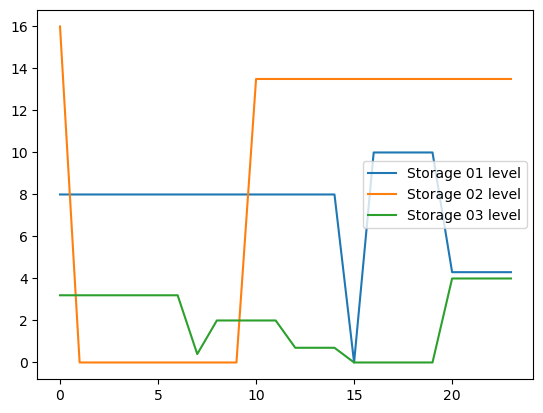

In [13]:
# Plot the storage

for s in range(1, 4):
    temp_storage = [episode_info[i]['storage_{:02d}'.format(s)]['current']
                    for i in range(len(episode_info) - 1)]
    plt.plot(temp_storage,
             label='Storage {:02d} level'.format(s))

plt.legend()
plt.plot()

[]

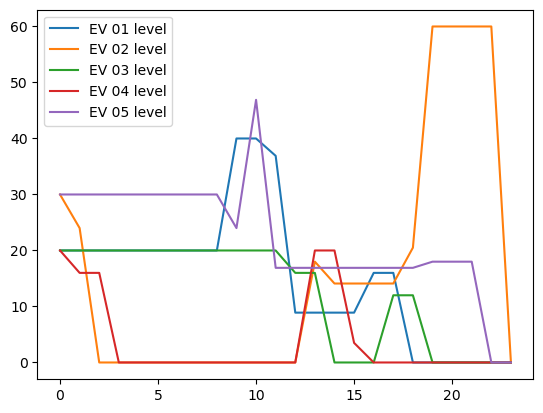

In [14]:
# Plot the EVs

for e in range(1, 6):
    temp_ev = [episode_info[i]['ev_{:02d}'.format(e)]['current']
               for i in range(len(episode_info) - 1)]
    plt.plot(temp_ev,
             label='EV {:02d} level'.format(e))

plt.legend()
plt.plot()

In [15]:
import torch

torch.device('cuda')

device(type='cuda')

In [19]:
torch.cuda.is_available()

False

In [17]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [18]:
import torch

print("Torch version:", torch.__version__)

print("Is CUDA enabled?", torch.cuda.is_available())

Torch version: 2.2.2+cpu
Is CUDA enabled? False
